In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
identifier_name = 'flight_id'

most_important_features_names = [
    'wtc', 
    'flown_distance', 
    'aircraft_type', 
    'groundspeed_max', 
    'airline', 
    'altitude_max', 
    'flight_duration', 
    'latitude_max', 
    'ades', 
    'adep', 
    'altitude_75percentile', 
    'altitude_median', 
    'longitude_max', 
    'vertical_rate_max', 
    'country_code_ades', 
    'longitude_min', 
    'latitude_min', 
    'vertical_rate_std', 
    'country_code_adep', 
    'longitude_std', 
    'altitude_25percentile', 
    'vertical_rate_75percentile', 
    'month', 
    'vertical_rate_25percentile', 
    'groundspeed_min', 
    'longitude_25percentile', 
    'latitude_25percentile', 
    'latitude_75percentile', 
    'taxiout_time', 
    'longitude_mean', 
    'longitude_median', 
    'month_day', 
    'latitude_mean', 
    'track_median', 
    'latitude_count', 
    'latitude_std', 
    'arrival_time_hour_minute', 
    'latitude_median', 
    'longitude_75percentile', 
    'track_75percentile', 
    'altitude_mean', 
    'temperature_min', 
    'actual_offblock_time_hour', 
    'vertical_rate_median', 
    'track_25percentile', 
    'vertical_rate_mean', 
    'arrival_time_hour', 
    'specific_humidity_median', 
    'altitude_std', 
    'actual_offblock_time_hour_minute', 
    'track_unwrapped_25percentile', 
    'altitude_min', 
    'temperature_max', 
    'temperature_75percentile', 
    'track_unwrapped_min', 
    'specific_humidity_max', 
    'temperature_median', 
    'track_unwrapped_mean', 
    'groundspeed_25percentile', 
    'specific_humidity_75percentile', 
    'groundspeed_75percentile', 
    'temperature_25percentile', 
    'track_unwrapped_median', 
    'track_mean', 
    'track_unwrapped_75percentile', 
    'specific_humidity_25percentile', 
    'groundspeed_mean', 
    'vertical_rate_min', 
    'v_component_of_wind_max', 
    'u_component_of_wind_75percentile', 
    'u_component_of_wind_median', 
    'track_std', 
    'v_component_of_wind_min', 
    'temperature_std', 
    'groundspeed_median', 
    'specific_humidity_std', 
    'track_unwrapped_max', 
    'track_max', 
    'v_component_of_wind_25percentile', 
    'groundspeed_std', 
    'u_component_of_wind_mean', 
    'u_component_of_wind_25percentile', 
    'temperature_mean', 
    'v_component_of_wind_75percentile', 
    'v_component_of_wind_median', 
    'specific_humidity_mean', 
    'specific_humidity_min', 
    'track_min', 
    'u_component_of_wind_min', 
    'track_unwrapped_std', 
    'u_component_of_wind_max', 
    'v_component_of_wind_mean', 
    'v_component_of_wind_std', 
    'u_component_of_wind_std', 
    'arrival_time_minute', 
    'day', 
    'actual_offblock_time_minute', 
    'track_unwrapped_count', 
    'track_count', 
    'groundspeed_count', 
    'specific_humidity_count', 
    'longitude_count', 
    'v_component_of_wind_count', 
    'temperature_count', 
    'vertical_rate_count', 
    'u_component_of_wind_count', 
    'altitude_count'
]

target_name = 'tow'

global_random_state = 123

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [4]:
def evaluate_model(model, data_df, features_columns, target_column):
    features = data_df[features_columns]
    target = data_df[target_column]
    X_array = features.values
    y_array = target.values
    rmse_scores = []
    kf = KFold(n_splits=3, shuffle=True, random_state=global_random_state)
    for train_index, test_index in kf.split(X_array):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(rmse(y_test, y_pred))
    return np.mean(rmse_scores)

In [5]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')
encoded_challenge_set = encoded_challenge_set.fillna(0)

In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=91,
    max_depth=10,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

rmse_score = evaluate_model(
    model=xgb_model, 
    data_df=encoded_challenge_set, 
    features_columns=most_important_features_names, 
    target_column=target_name
)
print("Evaluation RMSE:", rmse_score)

Evaluation RMSE: 3172.507881552716


In [7]:
num_top_features = []
all_rmse_scores = []

for top_important_features in range(1, len(most_important_features_names)+1):
    print(f"Trying top {top_important_features} important features...")
    
    current_top_features = most_important_features_names[0:top_important_features]
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=91,
        max_depth=10,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        objective='reg:squarederror', 
        eval_metric='rmse',
        random_state=global_random_state
    )
    
    rmse_score = evaluate_model(
        model=xgb_model, 
        data_df=encoded_challenge_set, 
        features_columns=current_top_features, 
        target_column=target_name
    )
    print("Evaluation RMSE:", rmse_score)
    num_top_features.append(len(current_top_features))
    all_rmse_scores.append(rmse_score)

Trying top 1 important features...
Evaluation RMSE: 20350.17311080975
Trying top 2 important features...
Evaluation RMSE: 15521.667890609824
Trying top 3 important features...
Evaluation RMSE: 6507.499493896105
Trying top 4 important features...
Evaluation RMSE: 6439.312649874511
Trying top 5 important features...
Evaluation RMSE: 4557.423479828336
Trying top 6 important features...
Evaluation RMSE: 4094.961741862028
Trying top 7 important features...
Evaluation RMSE: 4051.6776279168475
Trying top 8 important features...
Evaluation RMSE: 3954.3530547689097
Trying top 9 important features...
Evaluation RMSE: 3854.641054243128
Trying top 10 important features...
Evaluation RMSE: 3790.734095362914
Trying top 11 important features...
Evaluation RMSE: 3682.788535922445
Trying top 12 important features...
Evaluation RMSE: 3606.897258806947
Trying top 13 important features...
Evaluation RMSE: 3594.2156620337523
Trying top 14 important features...
Evaluation RMSE: 3451.004116580705
Trying top 

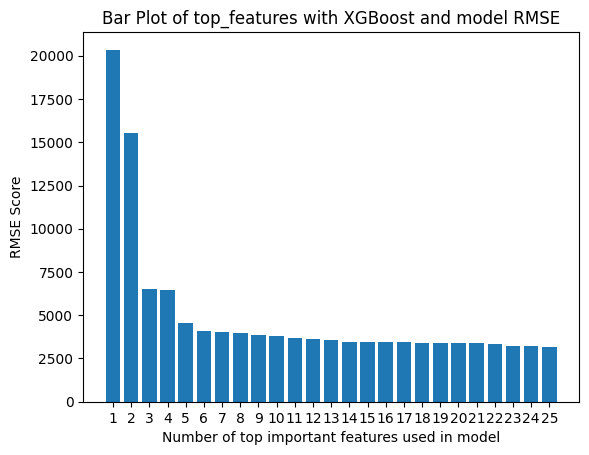

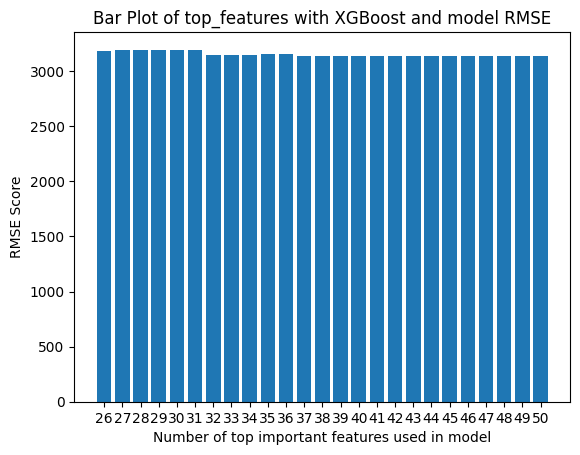

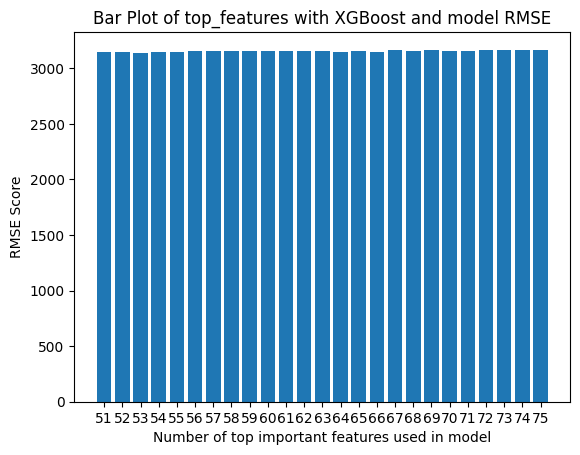

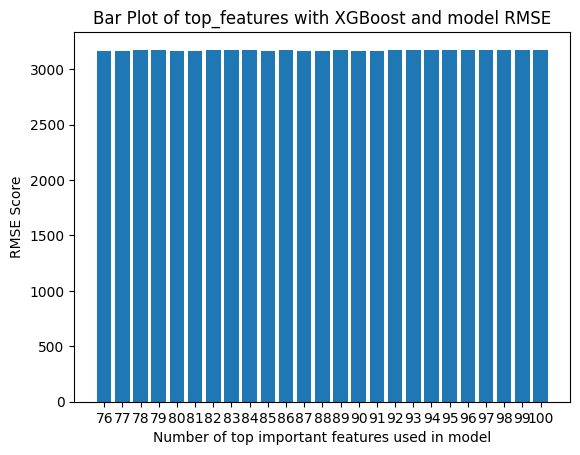

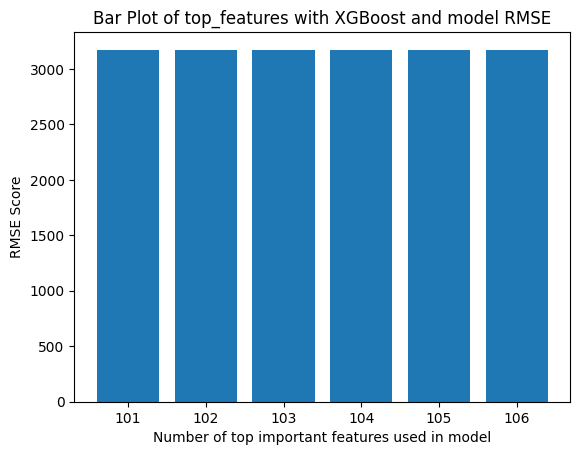

In [22]:
step = 25
for to_index in range(25, 126, step):
    from_index = to_index-step
    if to_index > len(all_rmse_scores)-1:
        to_index = len(all_rmse_scores)-1
    
    plt.bar(num_top_features[from_index:to_index], all_rmse_scores[from_index:to_index])
    plt.title(f"Bar Plot of top_features with XGBoost and model RMSE")
    plt.xlabel("Number of top important features used in model")
    plt.ylabel("RMSE Score")
    plt.xticks(ticks=num_top_features[from_index:to_index])
    plt.show()
    print()

In [29]:
print(f"Minimum RMSE: ", all_rmse_scores[np.argmin(all_rmse_scores)])

Minimum RMSE:  3133.6530725334173


In [30]:
print(f"Number of top features: ", num_top_features[np.argmin(all_rmse_scores)])

Number of top features:  47


In [37]:
print(f"Top features: ")
top_features_with_lowest_rmse = most_important_features_names[0: np.argmin(all_rmse_scores)+1]
print(top_features_with_lowest_rmse)
print(len(top_features_with_lowest_rmse))

Top features: 
['wtc', 'flown_distance', 'aircraft_type', 'groundspeed_max', 'airline', 'altitude_max', 'flight_duration', 'latitude_max', 'ades', 'adep', 'altitude_75percentile', 'altitude_median', 'longitude_max', 'vertical_rate_max', 'country_code_ades', 'longitude_min', 'latitude_min', 'vertical_rate_std', 'country_code_adep', 'longitude_std', 'altitude_25percentile', 'vertical_rate_75percentile', 'month', 'vertical_rate_25percentile', 'groundspeed_min', 'longitude_25percentile', 'latitude_25percentile', 'latitude_75percentile', 'taxiout_time', 'longitude_mean', 'longitude_median', 'month_day', 'latitude_mean', 'track_median', 'latitude_count', 'latitude_std', 'arrival_time_hour_minute', 'latitude_median', 'longitude_75percentile', 'track_75percentile', 'altitude_mean', 'temperature_min', 'actual_offblock_time_hour', 'vertical_rate_median', 'track_25percentile', 'vertical_rate_mean', 'arrival_time_hour']
47
